In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
from robot import *
robots = RobotDict("config_files/franka.yaml", ["config_files/contact.yaml", "config_files/free_space.yaml"]).param_dict
rob = robots['contact']
q = np.array([-0.58, 0.54, -0.39, -1.83, 0.27, 2.35, -2.68])
rob.fwd_kin(q)
rob.get_statedict(np.vstack((q, np.zeros(7))))


loading model: contact
Building robot model with:
  contact model(s):  ['contact_1']
  optimization pars: {}
  estimation pars:   {}
@1=0.0825, @2=cos(q_0), @3=cos(q_1), @4=sin(q_0), @5=2.22045e-16, @6=sin(q_1), @7=(@5*@6), @8=((@2*@3)-(@4*@7)), @9=cos(q_2), @10=(@5*@3), @11=((@2*@6)+(@4*@10)), @12=sin(q_2), @13=(@5*@12), @14=((@8*@9)-((@11*@13)+(@4*@12))), @15=-0.316, @16=-0.0825, @17=cos(q_3), @18=(@11-(@5*@4)), @19=sin(q_3), @20=(@5*@9), @21=((@8*@12)+((@11*@20)+(@4*@9))), @22=(@5*@19), @23=((@14*@17)+((@18*@19)-(@21*@22))), @24=0.384, @25=(@5*@17), @26=(((@18*@17)-(@21*@25))-(@14*@19)), @27=0.088, @28=cos(q_4), @29=sin(q_4), @30=(@5*@29), @31=(@21+(@5*@18)), @32=((@23*@28)+((@26*@30)-(@31*@29))), @33=cos(q_5), @34=(@5*@28), @35=(((@26*@34)-(@31*@28))-(@23*@29)), @36=sin(q_5), @37=(@5*@36), @38=(@26+(@5*@31)), @39=0.107, @40=(@5*@33), @41=((@5*((@5*@38)-@35))-(((@35*@40)+(@38*@33))-(@32*@36))), @42=0.05, @43=((@2*@10)-(@4*@6)), @44=((@4*@3)+(@2*@7)), @45=((@44*@9)+((@43*@13)+(@2*@12

RuntimeError: .../casadi/core/function_internal.hpp:1257: Input 0 (q) has mismatching shape. Got 2-by-7. Allowed dimensions, in general, are:
 - The input dimension N-by-M (here 7-by-1)
 - A scalar, i.e. 1-by-1
 - M-by-N if N=1 or M=1 (i.e. a transposed vector)
 - N-by-M1 if K*M1=M for some K (argument repeated horizontally)
 - N-by-P*M, indicating evaluation with multiple arguments (P must be a multiple of 1 for consistency with previous inputs)

This notebook tries to identify if there are issues when differentiating dynamic systems with respect to dynamic parameters.  It tries to find if there are ways to characterize when this identification is difficult, not unique, etc.

In [89]:
# Make some integrators
import casadi as ca
from copy import deepcopy

def explicit_euler(xi_d, xi, params, h):
    return xi + h*xi_d(xi, *params)

def symplectic_euler(xi_d, xi, h):
    xi_plus = deepcopy(xi)
    xd_plus = xi[1]+h*xi_d[1]
    x_plus = xi[0]+h*xd_plus[1]
    return ca.vertstack(x_plus, xd_plus)

In [96]:
# Have some dynamics, generate some data.
M = ca.SX.sym('M')
B = ca.SX.sym('B')
K = ca.SX.sym('K')
xi = ca.SX.sym('xi',2)
x_c = ca.SX.sym('x_c')

bias = 1

params = [M, B, K, x_c]

contact_force = ca.if_else(xi[0]>x_c, -K*(xi[0]-x_c), 0)
x_dd = 1/M*(-B*xi[1] - contact_force + bias)
xi_d = ca.Function('xdot', [xi, *params], [ca.vertcat(xi[1], x_dd)])

integrator = explicit_euler
h = 0.01
traj = [[-0.1, -0.3]]

#print(xi_d(traj[-1], *paramsp))
#print(integrator(xi_d, traj[-1], paramsp, h))

for _ in range(30):
    traj.append(integrator(xi_d, traj[-1], params, h))


traj_fn = ca.Function('traj', [*params], [*traj])
traj = ca.horzcat(*traj).T
print(traj[5,:])

@1=-0.103, @2=0.01, @3=-0.3, @4=1, @5=-0.1, @6=(@3+(@2*((@4-((@3*B)+((x_c<@5)?(-(K*(@5-x_c))):0)))/M))), @7=(@1+(@2*@6)), @8=(@6+(@2*((@4-((B*@6)+((x_c<@1)?(-(K*(@1-x_c))):0)))/M))), @9=(@7+(@2*@8)), @10=(@8+(@2*((@4-((B*@8)+((x_c<@7)?(-(K*(@7-x_c))):0)))/M))), @11=(@9+(@2*@10)), @12=(@10+(@2*((@4-((B*@10)+((x_c<@9)?(-(K*(@9-x_c))):0)))/M))), [[(@11+(@2*@12)), (@12+(@2*((@4-((B*@12)+((x_c<@11)?(-(K*(@11-x_c))):0)))/M)))]]


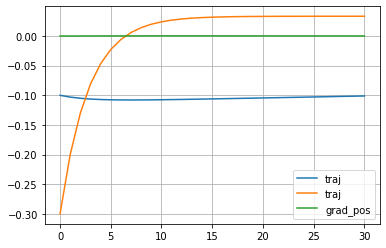

In [97]:
# Eval and plot
import matplotlib.pyplot as plt
Mp = 1; Bp = 30; Kp = 100
x_cp = 0.1
paramsp = [Mp, Bp, Kp, x_cp]

trajp = traj_fn(*paramsp)
traj_pts = ca.horzcat(*trajp).T.full()
plt.plot(traj_pts, label="traj")

p = B
dx_c_fn = ca.Function('dx', [*params], [ca.jacobian(traj[:,0], p)])
dx_c = dx_c_fn(*paramsp)
plt.plot(dx_c, label='grad_pos')
plt.legend()
plt.grid(True)


In [1]:
# Checking the impact of JIT on the performance 
from main import init_rosparams
from robot import Robot
from observer import ekf
import numpy as np
par = init_rosparams()
dyn_sys = Robot(par)
qm = np.ones(6)+np.random.randn(6)
tm = -np.ones(6)+np.random.randn(6)

obs = ekf(dyn_sys)
#obs2 = ekf(par, np.ones(6), est_geom = False)
#step_args = {'tau': np.zeros(6), 'xi': np.ones(12)}

# Checking cleaned-up dynamics, speed up ~30 micsec to ~20
#%timeit dyn_sys.disc_dyn.call(step_arg
#%timeit dyn_sys.disc_dyn2.call(step_args)
#res1 = dyn_sys.disc_dyn.call(step_args)
#res2 = dyn_sys.disc_dyn_opt.call(step_args)
#print(res1['xi_next']-res2['xi_next'])

# Checking approximation to A, speedup ~120 micsec to ~30
#%timeit dyn_sys.A_fn.call(step_args)['A']
#%timeit dyn_sys.A_fn2.call(step_args)['A']
#%timeit dyn_sys.A_fn3.call(step_args)['A']
#res1 = dyn_sys.A.call(step_args)['A']
#res3 = dyn_sys.A_opt.call(step_args)['A']
#print(res1-res3)

# Checking the optimized EKF step fn, speedup ~600 micsec to 75
#%timeit obs.step(np.ones(6), np.ones(6))
#%timeit obs.step_fast(np.ones(6), np.ones(6))
#res1 = obs.step(qm, tm)
#print(res1['cov']-res2['cov'])
#print(res1['mu'] - res2['mu'])

%timeit obs.step(np.ones(6), np.ones(6))

Building robot model with:
  contact model(s):  ['contact_1']
  optimization pars: {}
  estimation pars:   {}
49.5 µs ± 114 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [49]:
# Testing exporting a casadi fn
import casadi as ca
from main import init_rosparams
from robot import Robot
from observer import ekf
import numpy as np
par = init_rosparams()
dyn_sys = Robot(par)
#with open("disc_dyn.ca", "w") as text_file:
#    text_file.write(dyn_sys.disc_dyn.serialize())
#with open("A_fn.ca", "w") as text_file:
#    text_file.write(dyn_sys.A.serialize())
    
with open("disc_dyn.ca", "r") as text_file:
    st = text_file.read()
fn_read = ca.Function.deserialize(st)    

#q2.symvar(q)

Building robot model with
  optimization pars: {}
  estimation pars:   {}


Function(disc_dyn:(xi[12],tau[6])->(xi_next[12]) SXFunction)

It seems like *one* way this is unrealistic is that the trajectory is fully rolled out. If we're doing something like an EM approach (estimate state, fit dyn over the (state, state+) pairs) then some of this recursive aspects should drop out. 